In [1]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [2]:
def calibration():
    objpoints = []
    imgpoints = []
    
    images = glob.glob('./camera_cal/calibration*.jpg')
    
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    for fname in images:    
        print('Reading image {}'.format(fname))
        img = mpimg.imread(fname)        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)        
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        else:
            print('No grid found for {}'.format(fname))
        
    
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

ret, mtx, dist, rvecs, tvecs = calibration()

Reading image ./camera_cal/calibration7.jpg
Reading image ./camera_cal/calibration11.jpg
Reading image ./camera_cal/calibration3.jpg
Reading image ./camera_cal/calibration19.jpg
Reading image ./camera_cal/calibration4.jpg
No grid found for ./camera_cal/calibration4.jpg
Reading image ./camera_cal/calibration2.jpg
Reading image ./camera_cal/calibration20.jpg
Reading image ./camera_cal/calibration12.jpg
Reading image ./camera_cal/calibration13.jpg
Reading image ./camera_cal/calibration10.jpg
Reading image ./camera_cal/calibration1.jpg
No grid found for ./camera_cal/calibration1.jpg
Reading image ./camera_cal/calibration16.jpg
Reading image ./camera_cal/calibration14.jpg
Reading image ./camera_cal/calibration17.jpg
Reading image ./camera_cal/calibration9.jpg
Reading image ./camera_cal/calibration8.jpg
Reading image ./camera_cal/calibration5.jpg
No grid found for ./camera_cal/calibration5.jpg
Reading image ./camera_cal/calibration18.jpg
Reading image ./camera_cal/calibration15.jpg
Reading i

In [3]:
img = mpimg.imread('./camera_cal/calibration1.jpg')
final = cv2.undistort(img, mtx, dist, None, mtx)

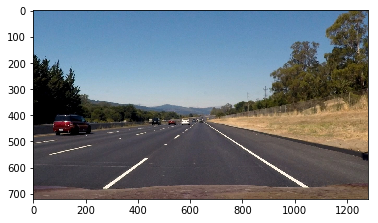

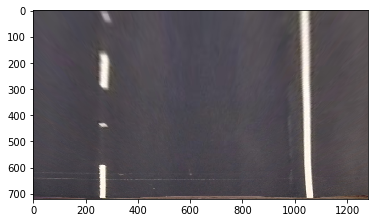

In [106]:
# Generate warp matrix
img_size = (1280, 720)
src_x_bottom = 250
src_y_bottom = 685

src_x_top = 570
src_y_top = 464
src_points = np.float32([
    [src_x_bottom, src_y_bottom],
    [src_x_top, src_y_top],
    [img_size[0]-src_x_top, src_y_top],
    [img_size[0]-src_x_bottom, src_y_bottom]
])

dst_points = np.float32([
    [src_x_bottom, img_size[1]],
    [src_x_bottom, 0],
    [img_size[0]-src_x_bottom, 0],
    [img_size[0]-src_x_bottom, img_size[1]]
])

M = cv2.getPerspectiveTransform(src_points, dst_points)
_, Minv = cv2.invert(M)



def warp_to_birdview(img): 
    img_size = (img.shape[1], img.shape[0])    

    warped = cv2.warpPerspective(ex_img1, M, img_size, flags=cv2.INTER_LINEAR)
    return warped
    
ex_img1 = mpimg.imread('./test_images/straight_lines2.jpg')
plt.imshow(ex_img1)
plt.show()

warped = warp_to_birdview(ex_img1)
plt.imshow(warped)
plt.show()

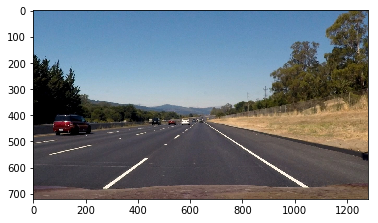

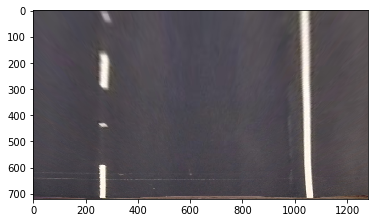

In [107]:
def warp_to_birdview(img):
    img_size = (img.shape[1], img.shape[0])    

    warped = cv2.warpPerspective(ex_img1, M, img_size, flags=cv2.INTER_LINEAR)
    return warped
    
ex_img1 = mpimg.imread('./test_images/straight_lines2.jpg')
plt.imshow(ex_img1)
plt.show()

warped = warp_to_birdview(ex_img1)
plt.imshow(warped)
plt.show()

In [108]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return scaled_sobel

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    arctan_thresh = [0.7, 1.3]
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= arctan_thresh[0]) & (absgraddir <= arctan_thresh[1])] = 1
    return binary_output

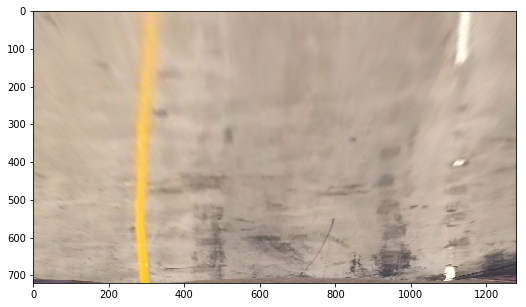

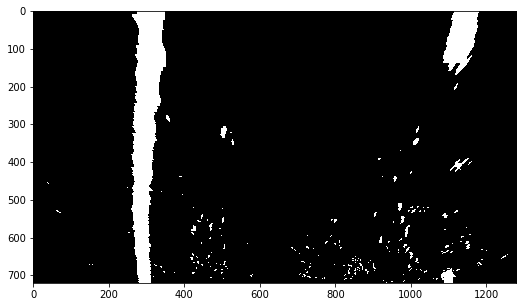

In [1152]:
def process_each_image_on_space(img):
    # Undistort based on camera calibration
    sobel_kernel_size = 15
    
    # Apply sobel
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel_size)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel_size)
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    mag_thresh = [80, 180]
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    mag_binary = binary_output
    
    arctan_thresh = [0.7, 1.3]
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= arctan_thresh[0]) & (absgraddir <= arctan_thresh[1])] = 1    
    dir_binary = binary_output
    
    sobel_thresh = 15
    combined = np.zeros_like(scaled_sobelx)
    combined[((scaled_sobelx >= sobel_thresh) & (scaled_sobely >= sobel_thresh)) | ((mag_binary == 1) & (dir_binary == 1))] = 1    

    return combined

def process_each_image(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    rgb = process_each_image_on_space(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,2]    
    h_thresh = (100, 255)
    h_binary = np.zeros_like(H)
    h_binary[(H > h_thresh[0]) & (H <= h_thresh[1])] = 1
    
    B = img[:,:,1]
    b_thresh = (0, 145)
    b_binary = np.ones_like(B)
    b_binary[(B > b_thresh[0]) & (B <= b_thresh[1])] = 0

    combined = np.zeros_like(H)        
    combined[ ((h_binary == 1)*1 + (b_binary == 1)*1 + (rgb == 1)*1) > 1 ] = 1
    img = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
    return img
    
    
    
ex_img1 = mpimg.imread('./test_images/test1.jpg')
plt.imshow(cv2.warpPerspective(ex_img1, M, img_size, flags=cv2.INTER_LINEAR))
plt.show()

img = process_each_image(ex_img1)
plt.imshow(img, cmap='gray')
plt.show()

In [137]:
previous_fits = None
def window_search(image_binary, masked_image, x_base):
    # Set number of windows and its height
    number_of_windows = 15
    window_height = np.int(image_binary.shape[0]/number_of_windows)
    
    if masked_image is not None:
        target_image = masked_image
    else:
        target_image = image_binary
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = target_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 70
    minpix = 40
        
    good_pixels = []
    x_current = np.int(0)    
    
    # Step through the windows one by one
    for window in range(number_of_windows):
        # Identify window boundaries in x and y (and right and left)        
        y_bottom, y_top = target_image.shape[0] - (window+1)*window_height, target_image.shape[0] - window*window_height
        x_win_bottom = x_base - margin
        x_win_top = x_base + margin        
    
        # Identify the nonzero pixels in x and y within the window
        win_good_pixels = ((nonzeroy >= y_bottom) & (nonzeroy < y_top) & (nonzerox >= x_win_bottom) & (nonzerox < x_win_top)).nonzero()[0]

        # Append these indices to the lists
        good_pixels.append(win_good_pixels)    
        
        # If good pixels found, then apped to ???
        # If you found > minpix pixels, recenter next window on their mean position
        if len(win_good_pixels) > minpix:
            x_current = np.int(np.mean(nonzerox[win_good_pixels]))
#             x_base = x_current

    # Concatenate the arrays of pixels into a flat pixel list
    good_pixels = np.concatenate(good_pixels)

    # Extract left and right line pixel positions
    final_x_pixels = nonzerox[good_pixels]
    final_y_pixels = nonzeroy[good_pixels] 
    
    # Recursively calls this function if the masked value failed    
    if len(final_x_pixels) == 0 or len(final_y_pixels) == 0:
        print('Calling recursion')
        final_x_pixels, final_y_pixels, x_current = window_search(image_binary, None, x_base)
    
    return final_x_pixels, final_y_pixels, x_current

def create_mask(binary_warped, fits):
    m = np.zeros_like(binary_warped)
    margin = 40
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fit = fits[0]
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    cv2.fillPoly(m, np.int_([left_line_pts]), 255)
    
    right_fit = fits[1]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    cv2.fillPoly(m, np.int_([right_line_pts]), 255)

    return m

def calculate_polynomials(binary_warped):
    global previous_fits
    
    # Histogram of the bottom half
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Divide histogram in 2 sizes and get peaks to determine bottom initial point
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base    
    
    masked_image = None
    if previous_fits is not None:
        mask = create_mask(binary_warped, previous_fits)
        masked_image = cv2.bitwise_and(binary_warped, binary_warped, mask=mask)
    
    # Create empty lists to receive left and right lane pixel indices
    leftx, lefty, leftx_current = window_search(binary_warped, masked_image, leftx_base)
    rightx, righty, rightx_current = window_search(binary_warped, masked_image, rightx_base)
    
#     print("Left: {}, {}".format(leftx, lefty))
#     print("Right: {}, {}".format(rightx, righty))

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if previous_fits is not None:
        left_fit = np.mean([left_fit, previous_fits[0]], axis=0)
        right_fit = np.mean([right_fit, previous_fits[1]], axis=0)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.int_([np.hstack((pts_left, pts_right))])
    
    # Transform it back to 3 dimension (rgb) and 128 mean uint8 array
    binary_warped = (binary_warped * 255).astype(np.uint8)
    binary_warped = np.dstack((binary_warped, binary_warped, binary_warped))    
    binary_warped = cv2.fillPoly(np.zeros_like(binary_warped), pts, (0,255, 0))

    newwarp = cv2.warpPerspective(binary_warped, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    
    left_curverad = ((1 + (2*left_fit[0]*src_y_bottom + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*src_y_bottom + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Cache the polynomials
    previous_fits = (left_fit, right_fit)

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*src_y_bottom*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*src_y_bottom*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')
    
    return newwarp, previous_fits

Original


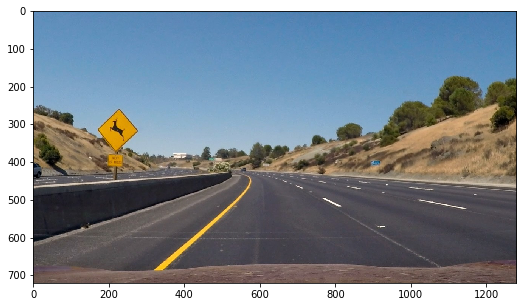

Processed


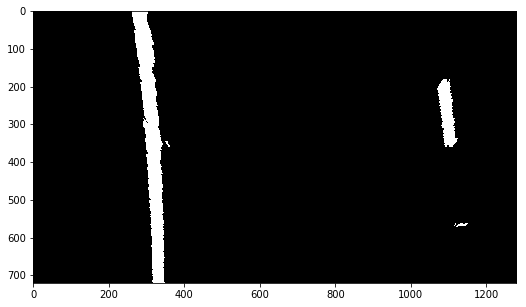

Original Masked


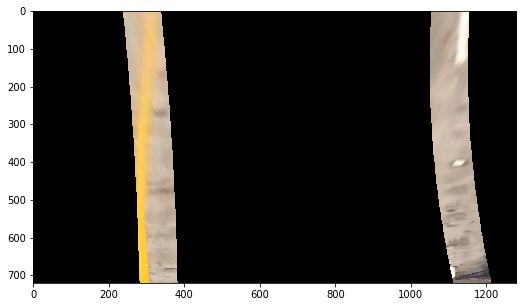

Processed Masked


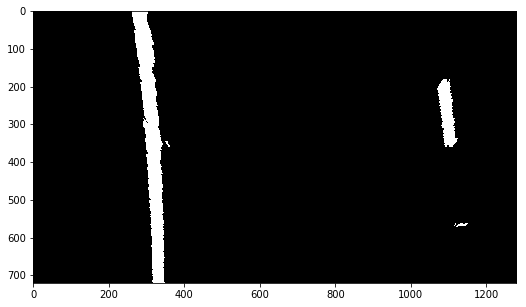

In [1154]:
previous_fits = None
def debug_image(img):
    print("Original")    
    plt.imshow(img)
    plt.show()

    print("Processed")
    processed = process_each_image(img)
    plt.imshow(processed, cmap='gray')
    plt.show()

    poly, previous_fits = calculate_polynomials(processed)

    # Create Mask
    mask = create_mask(processed, previous_fits)

    print("Original Masked")
    plt.imshow(cv2.bitwise_and(warp_to_birdview(img), warp_to_birdview(img), mask=mask))
    plt.show()

    print("Processed Masked")
    plt.imshow(cv2.bitwise_and(processed, processed, mask=mask), cmap='gray')
    plt.show()
    
    return poly
img = mpimg.imread('./test_images/test2.jpg')
_ = debug_image(img)


Original


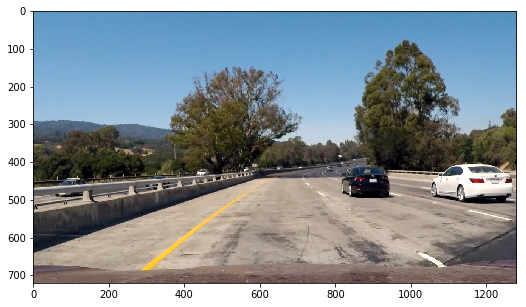

Processed


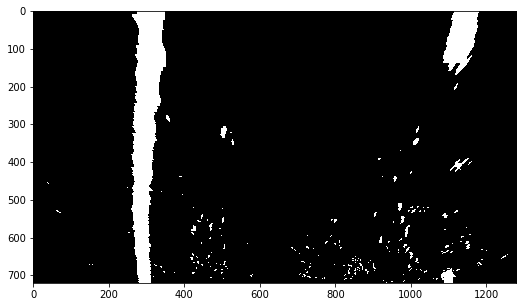

Original Masked


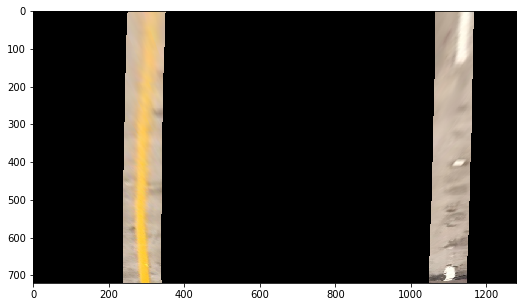

Processed Masked


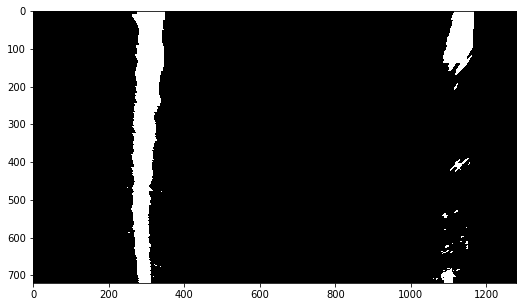

---
Original


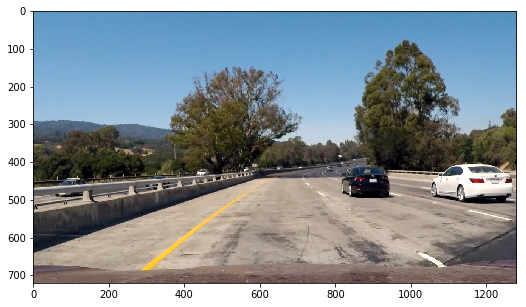

Processed


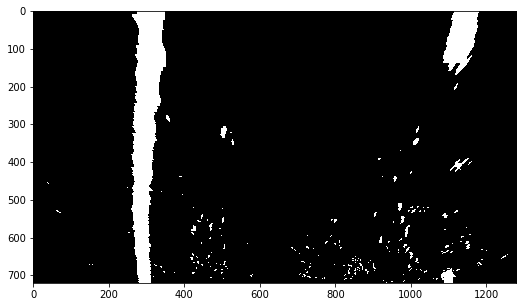

Original Masked


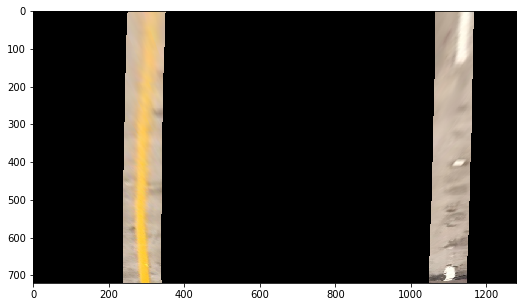

Processed Masked


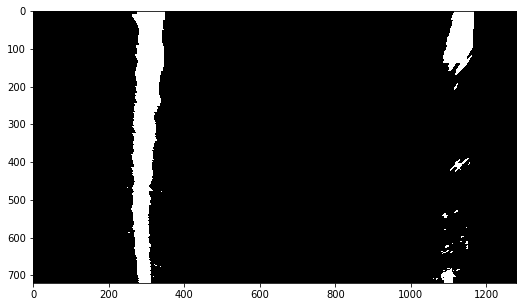

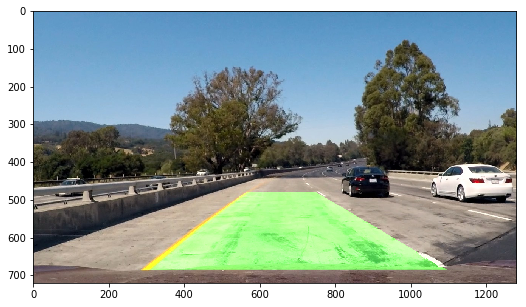

In [1155]:
previous_fits = None
def process(img):
    
    # Process the individual image
#     processed = process_each_image(img)
#     processed,_ = calculate_polynomials(processed)

    processed = debug_image(img)
    processed = cv2.addWeighted(img, 1.0, processed, 0.5, 0)

    return processed

# img = mpimg.imread('./test_images/straight_lines2.jpg')
img = mpimg.imread('./test_images/test1.jpg')
img = process(img)
print('---')
img = mpimg.imread('./test_images/test1.jpg')
img = process(img)
plt.imshow(img)
plt.show()

# image_names = glob.glob('./test_images/straight_lines*.jpg')        
# image_names = glob.glob('./test_images/test*.jpg')
# for fname in image_names:    
#     img = mpimg.imread(fname)        
#     img = process(img)
#     plt.imshow(img)
#     plt.show()


In [140]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lines = []

output_video = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
# clip1 = VideoFileClip("harder_challenge_video.mp4")
# clip1 = VideoFileClip("shorter.mp4")
output_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<03:42,  5.65it/s]

  0%|          | 2/1261 [00:00<03:48,  5.51it/s]

  0%|          | 3/1261 [00:00<03:42,  5.66it/s]

  0%|          | 4/1261 [00:00<03:36,  5.80it/s]

  0%|          | 5/1261 [00:00<03:38,  5.75it/s]

  0%|          | 6/1261 [00:01<03:34,  5.85it/s]

  1%|          | 7/1261 [00:01<03:31,  5.93it/s]

  1%|          | 8/1261 [00:01<03:28,  6.01it/s]

  1%|          | 9/1261 [00:01<03:31,  5.91it/s]

  1%|          | 10/1261 [00:01<03:32,  5.90it/s]

  1%|          | 11/1261 [00:01<03:29,  5.95it/s]

  1%|          | 12/1261 [00:02<03:34,  5.83it/s]

  1%|          | 13/1261 [00:02<03:34,  5.83it/s]

  1%|          | 14/1261 [00:02<03:31,  5.90it/s]

  1%|          | 15/1261 [00:02<03:32,  5.85it/s]

  1%|▏         | 16/1261 [00:02<03:30,  5.90it/s]

  1%|▏         | 17/1261 [00:02<03:32,  5.85it/s]

  1%|▏         | 18/1261 [00:03<03:31,  5.87it/s]

  2%|▏         | 19/1261 [00:03<03:31,  5.87it/

Calling recursion




 79%|███████▉  | 1002/1261 [02:58<00:47,  5.49it/s]

 80%|███████▉  | 1003/1261 [02:58<00:48,  5.37it/s]

 80%|███████▉  | 1004/1261 [02:58<00:46,  5.50it/s]

 80%|███████▉  | 1005/1261 [02:58<00:46,  5.46it/s]

 80%|███████▉  | 1006/1261 [02:58<00:45,  5.58it/s]

 80%|███████▉  | 1007/1261 [02:59<00:45,  5.56it/s]

 80%|███████▉  | 1008/1261 [02:59<00:44,  5.68it/s]

 80%|████████  | 1009/1261 [02:59<00:45,  5.54it/s]

 80%|████████  | 1010/1261 [02:59<00:45,  5.57it/s]

 80%|████████  | 1011/1261 [02:59<00:43,  5.72it/s]

 80%|████████  | 1012/1261 [02:59<00:44,  5.56it/s]

 80%|████████  | 1013/1261 [03:00<00:44,  5.52it/s]

 80%|████████  | 1014/1261 [03:00<00:43,  5.65it/s]

 80%|████████  | 1015/1261 [03:00<00:43,  5.67it/s]

 81%|████████  | 1016/1261 [03:00<00:43,  5.57it/s]

 81%|████████  | 1017/1261 [03:00<00:44,  5.49it/s]

 81%|████████  | 1018/1261 [03:01<00:43,  5.59it/s]

 81%|████████  | 1019/1261 [03:01<00:42,  5.71it/s]

 81%|████████  | 1020/1261 [03:01<00:42,  5.

[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 11min 59s, sys: 1.6 s, total: 12min
Wall time: 3min 44s
